<a href="https://colab.research.google.com/github/Yoav012/IntroToAeroTau/blob/main/Lab_partB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import os
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

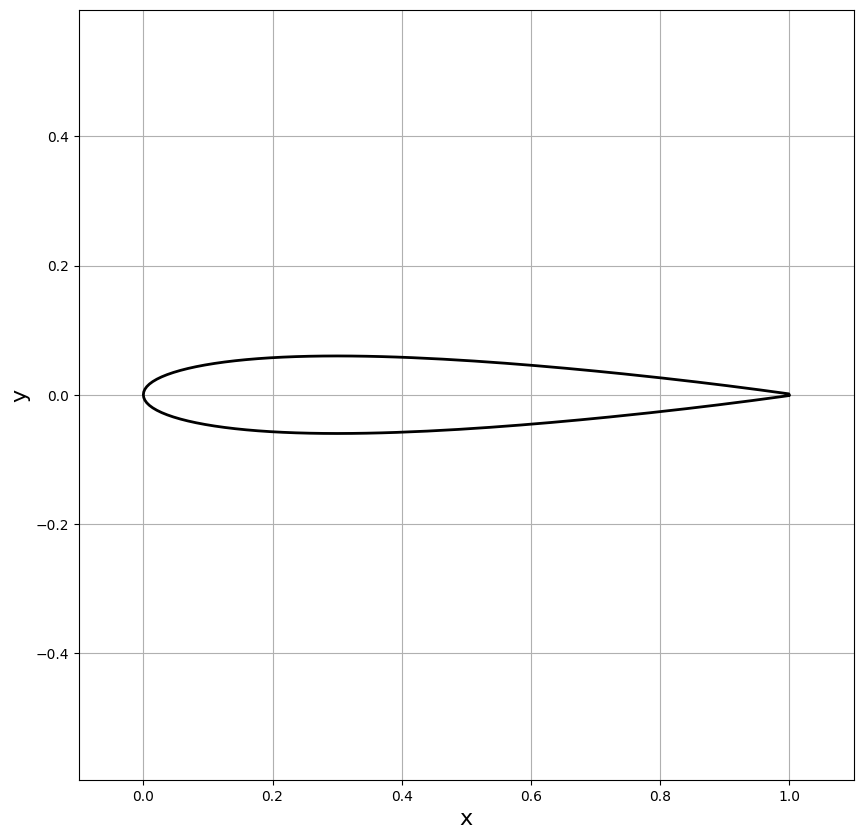

In [54]:
# read of the geometry from a data file
naca_filepath = 'naca0012.dat'
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)

# plot the geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('equal')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1);

In [55]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.

        Sets the end-points and calculates the center, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is on the lower or upper surface of the geometry.
        Initializes the source-sheet strength, tangential velocity,
        and pressure coefficient to zero.

        Parameters
        ----------
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb

        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # control-point (center-point)
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # length of the panel

        # orientation of the panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)

        # location of the panel
        if self.beta <= np.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'

        self.gamma = 0.0  # vortex strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [56]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.

    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.

    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
    R = (x.max() - x.min()) / 2  # radius of the circle
    x_center = (x.max() + x.min()) / 2  # x-coord of the center
    # define x-coord of the circle points
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * np.pi, N + 1))

    x_ends = np.copy(x_circle)  # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends)  # initialization of the y-coord Numpy array

    x, y = np.append(x, x[0]), np.append(y, y[0])  # extend arrays using numpy.append

    # computes the y-coordinate of end-points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]

    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

    return panels

(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.06601892),
 np.float64(0.06601892))

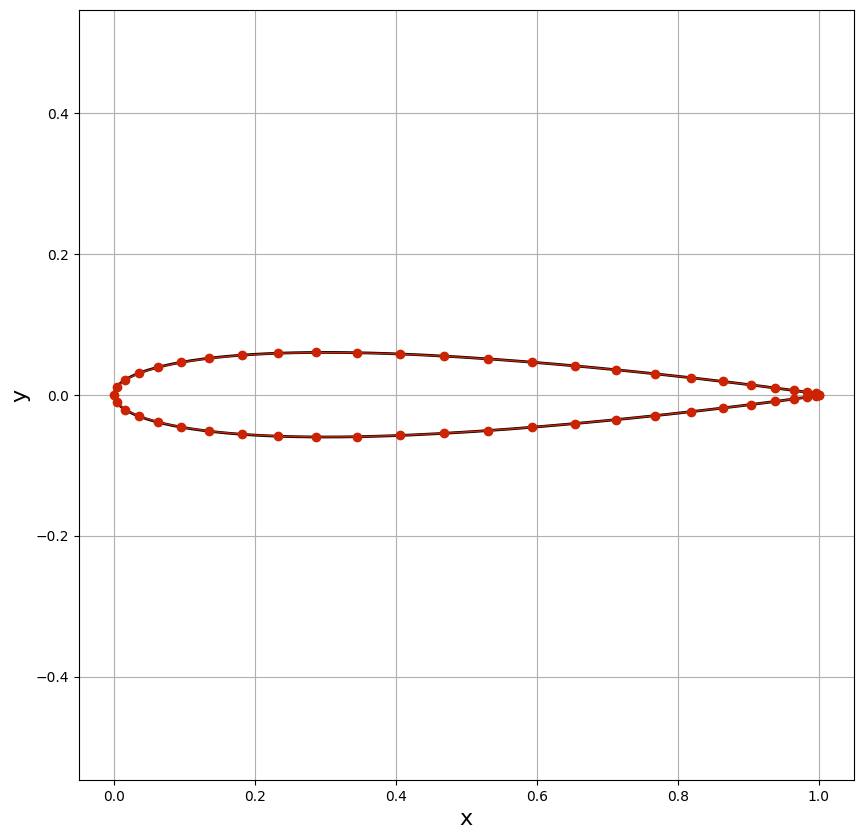

In [57]:
N = 50                           # number of panels
panels = define_panels(x, y, N)  # discretizes of the geometry into panels

# plot the geometry and the panels
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)
plt.axis('equal')

In [58]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (with the x-axis).

        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default: 0.0.
        """
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # degrees --> radians

In [59]:
# define and creates the object freestream
u_inf = 1.0                            # freestream spee
alpha = 10.0                            # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)  # instantiation of the object freestream

In [60]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.

    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.

    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [61]:
def build_matrix(panels):
    """
    Builds the (N+1)x(N+1) linear system matrix for the vortex panel method with Kutta condition.

    Parameters
    ----------
    panels : 1D array of Panel objects
        The vortex panels.

    Returns
    -------
    A : 2D numpy array of floats
        The influence matrix including Kutta condition (size (N+1)x(N+1)).
    """
    N = len(panels)
    A = np.empty((N + 1, N + 1), dtype=float)

    # ---------------------------
    # Part 1: Source Influence Matrix (NxN upper-left block)
    # ---------------------------
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i == j:
                A[i, j] = 0.5  # Self influence for sources
            else:
                A[i, j] = 0.5 / np.pi * integral(
                    p_i.xc, p_i.yc, p_j,
                    np.cos(p_i.beta), np.sin(p_i.beta)
                )

    # ---------------------------
    # Part 2: Vortex Influence Vector (Last column, first N rows)
    # ---------------------------
    for i, p_i in enumerate(panels):
        A[i, -1] = -0.5 / np.pi * sum(
            integral(p_i.xc, p_i.yc, p_j,
                     np.sin(p_i.beta), -np.cos(p_i.beta))
            for j, p_j in enumerate(panels) if i != j
        )

    # ---------------------------
    # Part 3: Kutta Condition Row (Last row of the matrix)
    # ---------------------------
    A[-1, :] = 0.0  # Initialize Kutta condition row

    # Contribution from first and last panels
    A[-1, 0] = 0.5 / np.pi * integral(
        panels[-1].xc, panels[-1].yc, panels[0],
        -np.sin(panels[-1].beta), np.cos(panels[-1].beta)
    )

    A[-1, -2] = 0.5 / np.pi * integral(
        panels[0].xc, panels[0].yc, panels[-1],
        -np.sin(panels[0].beta), np.cos(panels[0].beta)
    )

    # Contribution from all intermediate panels
    for i, panel in enumerate(panels[1:-1], start=1):
        # Source part of Kutta condition
        A[-1, i] = 0.5 / np.pi * (
            integral(panels[0].xc, panels[0].yc, panel,
                     -np.sin(panels[0].beta), np.cos(panels[0].beta))
            +
            integral(panels[-1].xc, panels[-1].yc, panel,
                     -np.sin(panels[-1].beta), np.cos(panels[-1].beta))
        )
        # Vortex part of Kutta condition (subtracting contribution from gamma_total)
        A[-1, -1] -= 0.5 / np.pi * (
            integral(panels[0].xc, panels[0].yc, panel,
                     np.cos(panels[0].beta), np.sin(panels[0].beta))
            +
            integral(panels[-1].xc, panels[-1].yc, panel,
                     np.cos(panels[-1].beta), np.sin(panels[-1].beta))
        )

    return A

def build_rhs(panels, freestream):
    """
    Builds the RHS vector for the linear system with Kutta condition.

    Parameters
    ----------
    panels : 1D array of Panel objects
        The vortex panels.
    freestream : Freestream object
        The freestream conditions.

    Returns
    -------
    b : 1D numpy array of floats
        RHS vector (size N+1).
    """
    N = len(panels)
    b = np.empty(N + 1, dtype=float)

    # Flow tangency condition (first N rows)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)

    # Kutta condition (last row)
    b[N] = -freestream.u_inf * (
        np.sin(freestream.alpha - panels[0].beta) +
        np.sin(freestream.alpha - panels[-1].beta)
    )

    return b

In [62]:
A = build_matrix(panels)           # compute the singularity matrix
b = build_rhs(panels, freestream)  # compute the freestream RHS

# Solve the linear system (A * x = b)
variables = np.linalg.solve(A, b)

# Store gamma values for each panel
for i, panel in enumerate(panels):
    panel.gamma = variables[i]

# Store total circulation (gamma)
gamma_total = variables[-1]

In [63]:
def get_tangential_velocity(panels, freestream, gamma_total):
    """
    Computes the tangential velocity on each panel's control point.

    Parameters
    ----------
    panels : 1D array of Panel objects
        The vortex panels.
    freestream : Freestream object
        Freestream conditions (velocity and angle of attack).
    gamma_total : float
        Total circulation (from Kutta condition).
    """
    N = len(panels)
    A = np.empty((N, N + 1), dtype=float)
    np.fill_diagonal(A, 0.0)  # Self-influence is zero for tangential velocity

    # Fill the NxN source influence part
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(
                    p_i.xc, p_i.yc, p_j,
                    -np.sin(p_i.beta), np.cos(p_i.beta)
                )

    # Fill the γ_total influence column
    for i, p_i in enumerate(panels):
        A[i, -1] = -0.5 / np.pi * sum(
            integral(
                p_i.xc, p_i.yc, p_j,
                np.cos(p_i.beta), np.sin(p_i.beta)
            )
            for j, p_j in enumerate(panels) if i != j
        )

    # Build RHS vector (freestream contribution)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta for panel in panels])

    # Build variables vector: [sigma1, sigma2, ..., sigmaN, gamma_total]
    variables = np.append([panel.gamma for panel in panels], gamma_total)

    # Solve for tangential velocities
    vt = np.dot(A, variables) + b

    # Store result in each panel
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [64]:
# compute the tangential velocity at the center-point of each panel
get_tangential_velocity(panels, freestream, gamma_total)

In [65]:
def get_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients on the panels.

    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [66]:
# computes the surface pressure coefficients
get_pressure_coefficient(panels, freestream)

In [67]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                           1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044,
                           0.956, 0.906, 0.0])
print(voverVsquared)
xtheo=np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                   40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100
print(xtheo)

[0.    0.64  1.01  1.241 1.378 1.402 1.411 1.411 1.399 1.378 1.35  1.288
 1.228 1.166 1.109 1.044 0.956 0.906 0.   ]
[0.     0.005  0.0125 0.025  0.05   0.075  0.1    0.15   0.2    0.25
 0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.95   1.    ]


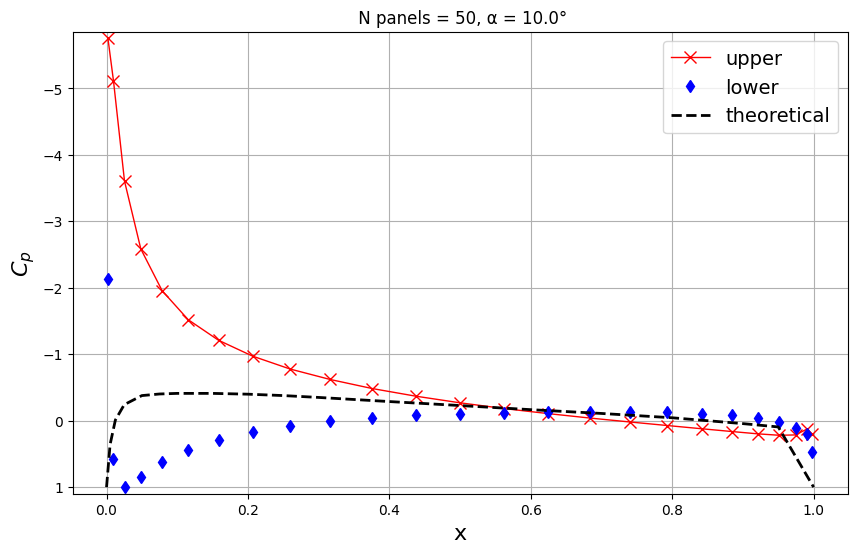

In [68]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)

# Plot upper surface
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
         [panel.cp for panel in panels if panel.loc == 'upper'],
         label='upper',
         color='r', linewidth=1, marker='x', markersize=8)

# Plot lower surface
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
         [panel.cp for panel in panels if panel.loc == 'lower'],
         label='lower',
         color='b', linewidth=0, marker='d', markersize=6)

# Plot theoretical result (if exists)
plt.plot(xtheo, 1 - voverVsquared,
         label='theoretical',
         color='k', linestyle='--', linewidth=2)

plt.legend(loc='best', prop={'size': 14})

# Dynamic axis limits based on data range
x_values = [panel.xc for panel in panels]
cp_values = [panel.cp for panel in panels]

plt.xlim(min(x_values) - 0.05, max(x_values) + 0.05)
plt.ylim(min(cp_values) - 0.1, max(cp_values) + 0.1)
plt.gca().invert_yaxis()

plt.title(f' N panels = {N}, α = {alpha:.1f}°')
plt.show()

In [69]:
accuracy = sum([panel.gamma * panel.length for panel in panels])
print('--> Total integrated gamma (accuracy check):', accuracy)

--> Total integrated gamma (accuracy check): 0.003494965148129506


In [70]:
chord = max(panel.xa for panel in panels) - min(panel.xa for panel in panels)
cl = gamma_total * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * chord)
print(f"Alpha = {alpha:.2f}°, Cl = {cl:.4f}")

Alpha = 10.00°, Cl = 1.3737


In [71]:
def get_velocity_field(panels, freestream, X, Y, gamma_total):
    """
    Computes the velocity field (u, v) at each point (X, Y) for the Vortex Panel Method.

    Parameters
    ----------
    panels : 1D array of Panel objects
        The vortex panels.
    freestream : Freestream object
        Freestream conditions (speed and angle of attack).
    X, Y : 2D numpy arrays
        Mesh grid coordinates for the field.
    gamma_total : float
        Total circulation (from Kutta condition).

    Returns
    -------
    u, v : 2D numpy arrays
        x and y components of the velocity field at each grid point.
    """
    u = np.full_like(X, freestream.u_inf * np.cos(freestream.alpha))
    v = np.full_like(Y, freestream.u_inf * np.sin(freestream.alpha))

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            u_sum = 0.0
            v_sum = 0.0
            x_point = X[i, j]
            y_point = Y[i, j]

            for panel in panels:
                def u_vortex(x, y, panel):
                    def integrand(s):
                        x_panel = panel.xa - np.sin(panel.beta) * s
                        y_panel = panel.ya + np.cos(panel.beta) * s
                        dx = x - x_panel
                        dy = y - y_panel
                        return (dy) / (dx**2 + dy**2)
                    return -(panel.gamma / (2 * np.pi)) * integrate.quad(integrand, 0, panel.length)[0]

                def v_vortex(x, y, panel):
                    def integrand(s):
                        x_panel = panel.xa - np.sin(panel.beta) * s
                        y_panel = panel.ya + np.cos(panel.beta) * s
                        dx = x - x_panel
                        dy = y - y_panel
                        return -(dx) / (dx**2 + dy**2)
                    return -(panel.gamma / (2 * np.pi)) * integrate.quad(integrand, 0, panel.length)[0]

                u_sum += u_vortex(x_point, y_point, panel)
                v_sum += v_vortex(x_point, y_point, panel)


            u[i, j] += u_sum
            v[i, j] += v_sum

    return u, v


In [72]:
Nx, Ny = 40, 40  # grid resolution
val_x, val_y = 1.0, 2.0

x_min, x_max = min(panel.xa for panel in panels), max(panel.xa for panel in panels)
y_min, y_max = min(panel.ya for panel in panels), max(panel.ya for panel in panels)

x_start, x_end = x_min - val_x * (x_max - x_min), x_max + val_x * (x_max - x_min)
y_start, y_end = y_min - val_y * (y_max - y_min), y_max + val_y * (y_max - y_min)

X, Y = np.meshgrid(
    np.linspace(x_start, x_end, Nx),
    np.linspace(y_start, y_end, Ny)
)


In [73]:
u, v = get_velocity_field(panels, freestream, X, Y, gamma_total)


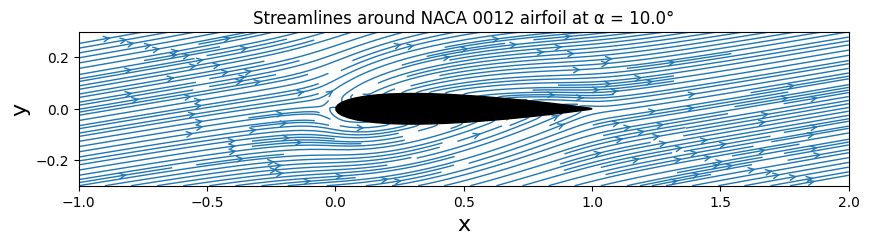

In [74]:
size = 10
plt.figure(figsize=(size, (y_end - y_start) / (x_end - x_start) * size))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(f"Streamlines around NACA 0012 airfoil at α = {alpha:.1f}°")
plt.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')

# Plot airfoil surface (using panel control points or endpoints)
plt.fill(
    [panel.xc for panel in panels],
    [panel.yc for panel in panels],
    color='k', zorder=3
)

plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.gca().set_aspect('equal')
plt.show()


In [75]:
alpha_range = np.linspace(0, 12, 30)

In [76]:
cl_values = []

for alpha_deg in alpha_range:
    # Update freestream with current angle
    freestream = Freestream(u_inf=1.0, alpha=alpha_deg)

    # Rebuild the matrix and RHS for this α
    A = build_matrix(panels)
    b = build_rhs(panels, freestream)

    # Solve linear system
    variables = np.linalg.solve(A, b)

    # Assign gamma for each panel
    for i, panel in enumerate(panels):
        panel.sigma = variables[i]
    gamma_total = variables[-1]

    # Calculate tangential velocities and Cp
    get_tangential_velocity(panels, freestream, gamma_total)
    get_pressure_coefficient(panels, freestream)

    # Calculate lift coefficient Cl
    chord = max(panel.xa for panel in panels) - min(panel.xa for panel in panels)
    cl = gamma_total * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * chord)
    cl_values.append(cl)

Slope (dCl/dα) = 0.1372 per degree
Slope (dCl/dα) = 7.8583 per radian


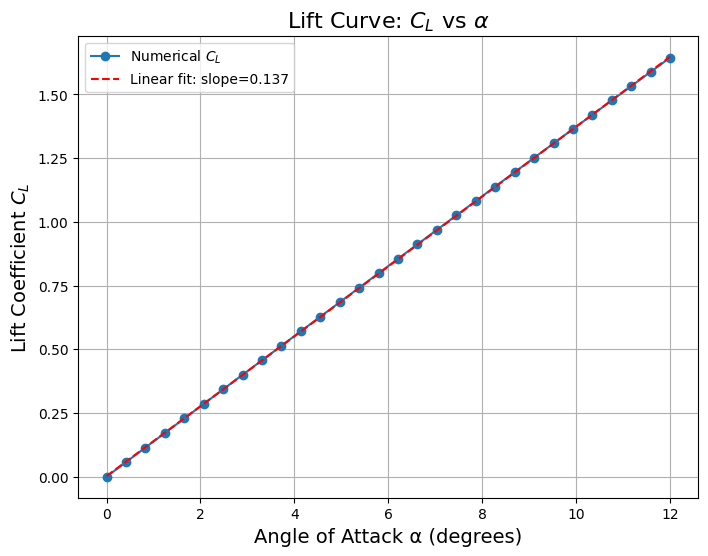

In [77]:
from scipy.stats import linregress

# Convert alpha_range to numpy array (just in case)
alpha_array = np.array(alpha_range)
cl_array = np.array(cl_values)

# Calculate linear regression (slope, intercept, etc.)
slope, intercept, r_value, p_value, std_err = linregress(alpha_array, cl_array)

print(f"Slope (dCl/dα) = {slope:.4f} per degree")

# Optional: if you want slope in per radian:
slope_per_radian = slope * (180/np.pi)
print(f"Slope (dCl/dα) = {slope_per_radian:.4f} per radian")

# Plot as before
plt.figure(figsize=(8, 6))
plt.plot(alpha_array, cl_array, marker='o', linestyle='-', label='Numerical $C_L$')

# Plot regression line for visualization
plt.plot(alpha_array, intercept + slope * alpha_array, 'r--', label=f'Linear fit: slope={slope:.3f}')

plt.xlabel('Angle of Attack α (degrees)', fontsize=14)
plt.ylabel('Lift Coefficient $C_L$', fontsize=14)
plt.title('Lift Curve: $C_L$ vs $\\alpha$', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

Angle of attack: α = 10.00°, Theoretical Cl = 1.0966

N =  16 | Cl_numerical = 2.0462 | Error vs Theory = +86.59%
N =  32 | Cl_numerical = 1.7481 | Error vs Theory = +59.40%
N =  64 | Cl_numerical = 1.6028 | Error vs Theory = +46.16%
N = 128 | Cl_numerical = 1.5372 | Error vs Theory = +40.17%


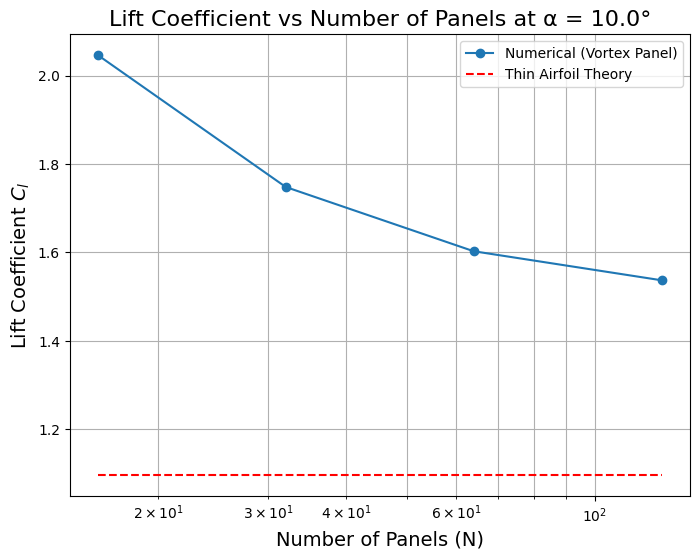

In [78]:
N_list = [16, 32, 64, 128]
cl_numerical = []

# Calculate theoretical Cl from Thin Airfoil Theory (alpha is in degrees, so we convert to radians here)
cl_theoretical = 2 * np.pi * np.radians(alpha)

print(f"Angle of attack: α = {alpha:.2f}°, Theoretical Cl = {cl_theoretical:.4f}\n")

for N in N_list:
    # Redefine panels for current N
    panels = define_panels(x, y, N)

    # Build and solve the linear system (freestream already exists and has correct alpha)
    A = build_matrix(panels)
    b = build_rhs(panels, freestream)
    variables = np.linalg.solve(A, b)

    # Assign gamma to each panel
    for i, panel in enumerate(panels):
        panel.sigma = variables[i]
    gamma_total = variables[-1]

    # Calculate tangential velocity and Cp
    get_tangential_velocity(panels, freestream, gamma_total)
    get_pressure_coefficient(panels, freestream)

    # Calculate Cl
    chord = max(panel.xa for panel in panels) - min(panel.xa for panel in panels)
    cl = gamma_total * sum(panel.length for panel in panels) / (0.5 * freestream.u_inf * chord)
    cl_numerical.append(cl)

    # Calculate error vs theory
    error_percent = 100 * (cl - cl_theoretical) / cl_theoretical if cl_theoretical != 0 else 0.0

    # Print result for this N
    print(f"N = {N:3d} | Cl_numerical = {cl:.4f} | Error vs Theory = {error_percent:+.2f}%")

# Plot Cl vs N with theoretical reference
plt.figure(figsize=(8, 6))
plt.plot(N_list, cl_numerical, marker='o', linestyle='-', label='Numerical (Vortex Panel)')
plt.hlines(cl_theoretical, N_list[0], N_list[-1], colors='r', linestyles='--', label='Thin Airfoil Theory')
plt.xscale('log')
plt.xlabel('Number of Panels (N)', fontsize=14)
plt.ylabel('Lift Coefficient $C_l$', fontsize=14)
plt.title(f'Lift Coefficient vs Number of Panels at α = {alpha:.1f}°', fontsize=16)
plt.grid(True, which='both')
plt.legend()
plt.show()